This notebook uses `numpyro` and replicates experiments in references [1] and [2] which evaluates the performance of HMC/NUTS on various frameworks. The benchmark is run with CUDA 10.0 on a NVIDIA RTX 2070.

In [1]:
%matplotlib inline

import time

import matplotlib.pyplot as plt
import numpy as onp
import tqdm
from sklearn.datasets import fetch_covtype

import jax.numpy as np
from jax import jit, random
# NB: replace gpu by cpu to run this notebook in cpu
from jax.config import config; config.update("jax_platform_name", "gpu")
from jax.tree_util import tree_map, tree_multimap

import numpyro.distributions as dist
from numpyro.handlers import sample
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import hmc_kernel

We do preprocessing steps as in [source code](https://github.com/google-research/google-research/blob/master/simple_probabilistic_programming/no_u_turn_sampler/logistic_regression.py) of reference [2]:

In [2]:
data = fetch_covtype()
features = data.data
labels = data.target

# normalize features and add intercept
features = (features - features.mean(0)) / features.std(0)
features = np.hstack([features, np.ones((features.shape[0], 1))])

# make binary feature
_, counts = onp.unique(labels, return_counts=True)
specific_category = np.argmax(counts)
labels = (labels == specific_category)

N, dim = features.shape
print("Data shape:", features.shape)
print("Label distribution: {} has label 1, {} has label 0"
      .format(labels.sum(), N - labels.sum()))

Data shape: (581012, 55)
Label distribution: 211840 has label 1, 369172 has label 0


Now, we construct the model:

In [3]:
def model(data, labels):
    coefs = sample('coefs', dist.norm(np.zeros(dim), np.ones(dim)))
    logits = np.dot(data, coefs)
    return sample('obs', dist.bernoulli(logits, is_logits=True), obs=labels)

And make a convenience mcmc implementation:

In [4]:
def mcmc(sample_kernel, state, num_samples, transform):
    for i in tqdm.tqdm(range(num_samples)):
        state = sample_kernel(state)
        state_out = transform(tree_map(lambda x: np.expand_dims(x, axis=0), state))
        if i == 0:
            states = state_out
        else:
            states = tree_multimap(lambda x, y: np.concatenate((x, y))
                                   if x is not None else None, states, state_out)
    return states

### Benchmark HMC

In [5]:
num_steps, num_samples = 10, 100
step_size = np.sqrt(0.5 / N)
init_params = {"coefs": np.zeros(dim)}

_, potential_fn = initialize_model(random.PRNGKey(1), model, (features, labels,), {})
init_kernel, sample_kernel = hmc_kernel(potential_fn, algo="HMC")
hmc_state, _, _ = init_kernel(init_params, num_warmup_steps=0, step_size=step_size,
                              num_steps=num_steps, run_warmup=False)

jsample_kernel = jit(sample_kernel)
start = time.time()
hmc_state = hmc_state.update(step_size=1.)  # HACK: force fast compiling!
jsample_kernel(hmc_state)
hmc_state = hmc_state.update(step_size=step_size)
print("time to compile sample_kernel:", time.time() - start)

time to compile sample_kernel: 2.626819610595703


In [6]:
start = time.time()
hmc_states = mcmc(jsample_kernel, hmc_state, num_samples,
                  transform=lambda state: {"coefs": state.z["coefs"],
                                           "num_steps": state.num_steps})
num_leapfrogs = np.sum(hmc_states["num_steps"]).copy()
print("number of leapfrog steps:", num_leapfrogs)
print("avg. time for each step :", (time.time() - start) / num_leapfrogs)

100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


number of leapfrog steps: 1000
avg. time for each step : 0.019120337963104247


In CPU, we get `avg. time for each step : 0.04372366189956665`.

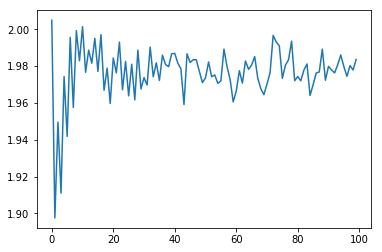

In [7]:
plt.plot(hmc_states["coefs"][:, 0]);

### Benchmark NUTS

In [8]:
num_samples = 10
step_size = 0.00167132
init_params = {"coefs": np.array(
    [+2.03420663e+00, -3.53567265e-02, -1.49223924e-01, -3.07049364e-01,
     -1.00028366e-01, -1.46827862e-01, -1.64167881e-01, -4.20344204e-01,
     +9.47479829e-02, -1.12681836e-02, +2.64442056e-01, -1.22087866e-01,
     -6.00568838e-02, -3.79419506e-01, -1.06668741e-01, -2.97053963e-01,
     -2.05253899e-01, -4.69537191e-02, -2.78072730e-02, -1.43250525e-01,
     -6.77954629e-02, -4.34899796e-03, +5.90927452e-02, +7.23133609e-02,
     +1.38526391e-02, -1.24497898e-01, -1.50733739e-02, -2.68872194e-02,
     -1.80925727e-02, +3.47936489e-02, +4.03552800e-02, -9.98773426e-03,
     +6.20188080e-02, +1.15002751e-01, +1.32145107e-01, +2.69109547e-01,
     +2.45785132e-01, +1.19035013e-01, -2.59744357e-02, +9.94279515e-04,
     +3.39266285e-02, -1.44057125e-02, -6.95222765e-02, -7.52013028e-02,
     +1.21171586e-01, +2.29205526e-02, +1.47308692e-01, -8.34354162e-02,
     -9.34122875e-02, -2.97472421e-02, -3.03937674e-01, -1.70958012e-01,
     -1.59496680e-01, -1.88516974e-01, -1.20889175e+00])}

In [9]:
_, potential_fn = initialize_model(random.PRNGKey(1), model, (features, labels,), {})
init_kernel, sample_kernel = hmc_kernel(potential_fn, algo="NUTS")
hmc_state, _, _ = init_kernel(init_params, num_warmup_steps=0, step_size=step_size, 
                              run_warmup=False)

jsample_kernel = jit(sample_kernel)
start = time.time()
hmc_state = hmc_state.update(step_size=1.)  # HACK: force fast compiling!
jsample_kernel(hmc_state)
hmc_state = hmc_state.update(step_size=step_size)
print("time to compile sample_kernel:", time.time() - start)

time to compile sample_kernel: 7.71427059173584


In [10]:
start = time.time()
hmc_states = mcmc(jsample_kernel, hmc_state, num_samples,
                  transform=lambda state: {"coefs": state.z["coefs"],
                                           "num_steps": state.num_steps})
num_leapfrogs = np.sum(hmc_states["num_steps"]).copy()
print("number of leapfrog steps:", num_leapfrogs)
print("avg. time for each step :", (time.time() - start) / num_leapfrogs)

100%|██████████| 10/10 [00:13<00:00,  2.03s/it]

number of leapfrog steps: 3070
avg. time for each step : 0.004387063700523749


In CPU, we get `avg. time for each step : 0.040541882929973176`.

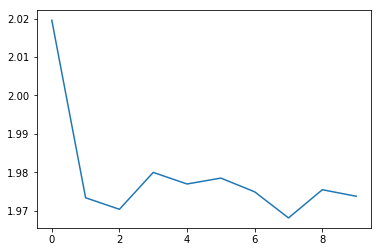

In [11]:
plt.plot(hmc_states["coefs"][:, 0]);

Comparing to HMC with similar trajectory:

In [13]:
num_steps, num_samples = 300, 10
step_size = np.sqrt(0.5 / N)
init_params = {"coefs": np.zeros(dim)}

_, potential_fn = initialize_model(random.PRNGKey(1), model, (features, labels,), {})
init_kernel, sample_kernel = hmc_kernel(potential_fn, algo="HMC")
hmc_state, _, _ = init_kernel(init_params, num_warmup_steps=0, step_size=step_size,
                              num_steps=num_steps, run_warmup=False)

jsample_kernel = jit(sample_kernel)
hmc_state = hmc_state.update(step_size=1.)  # HACK: force fast compiling!
jsample_kernel(hmc_state)
hmc_state = hmc_state.update(step_size=step_size)

start = time.time()
hmc_states = mcmc(jsample_kernel, hmc_state, num_samples,
                  transform=lambda state: {"coefs": state.z["coefs"],
                                           "num_steps": state.num_steps})
num_leapfrogs = np.sum(hmc_states["num_steps"]).copy()
print("number of leapfrog steps:", num_leapfrogs)
print("avg. time for each step :", (time.time() - start) / num_leapfrogs)

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

number of leapfrog steps: 3000
avg. time for each step : 0.0037791891892751056


Some takeaways:
+ The overhead of iterative NUTS is small. So most of computation time is indeed spent for evaluating potential function and its gradient.
+ The average speed of long trajectory is better than short trajectory.
+ GPU outperforms CPU by a large margin. The data is large, so evaluating potential function in GPU is clearly faster than doing so in CPU.
+ Iterative NUTS is 1.7x faster (in both GPU and CPU) than the reported speed in reference [2]. This illustates the win of a graph-mode (built using iterative algorithm) NUTS over an eager-mode (built using recursive algorithm) NUTS.

### References

1. `Deep Probabilistic Programming`, [arxiv](https://arxiv.org/abs/1701.03757)<br/>
Dustin Tran, Matthew D. Hoffman, Rif A. Saurous, Eugene Brevdo, Kevin Murphy, David M. Blei

2. `Simple, Distributed, and Accelerated Probabilistic Programming,` [arxiv](https://arxiv.org/abs/1811.02091)<br/>
Dustin Tran, Matthew D. Hoffman, Dave Moore, Christopher Suter, Srinivas Vasudevan, Alexey Radul, Matthew Johnson, Rif A. Saurous